In [161]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
from ta.trend import EMAIndicator
from sklearn.preprocessing import MinMaxScaler, StandardScaler





In [162]:
# Download data
ticker = "AAPL"
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796013,72.856606,71.545380,71.799866,135480400
2020-01-03,72.088295,72.851761,71.862892,72.020432,146322800
2020-01-06,72.662704,72.701485,70.953995,71.206062,118387200
2020-01-07,72.320984,72.929329,72.100426,72.672417,108872000
2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200


In [163]:
df.reset_index(inplace=True)
# df.drop(columns=['Date'], inplace=True)
df.columns = df.columns.droplevel('Ticker')
df.columns.name = None 
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,72.796013,72.856606,71.545380,71.799866,135480400
1,2020-01-03,72.088295,72.851761,71.862892,72.020432,146322800
2,2020-01-06,72.662704,72.701485,70.953995,71.206062,118387200
3,2020-01-07,72.320984,72.929329,72.100426,72.672417,108872000
4,2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200


In [164]:
# df.drop(columns=['High', 'Low', 'Open'], inplace=True)
# df.head()


In [165]:
MA100 = df['Close'].rolling(window=100).mean()
MA200 = df['Close'].rolling(window=200).mean()
MA50 = df['Close'].rolling(window=50).mean()



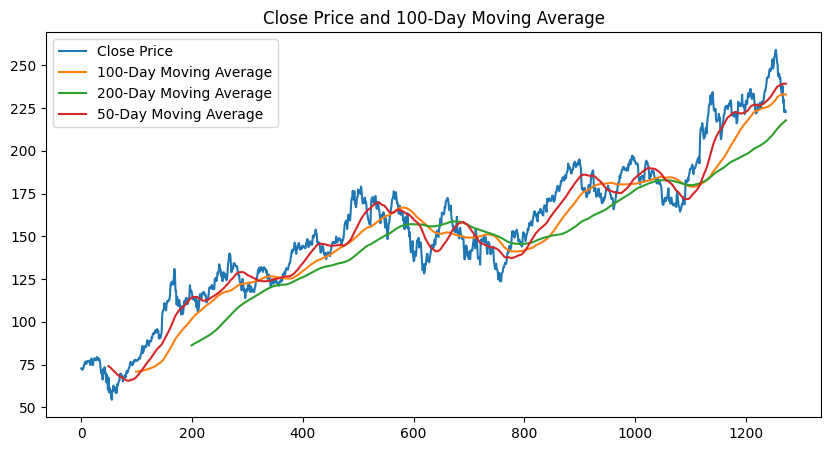

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(MA100, label='100-Day Moving Average')
plt.plot(MA200, label='200-Day Moving Average')
plt.plot(MA50, label='50-Day Moving Average')
plt.title('Close Price and 100-Day Moving Average')
plt.legend()
plt.show()


In [167]:
 # RSI
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
 # MACD
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df.head()
    

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
0,2020-01-02,72.796013,72.856606,71.545380,71.799866,135480400,NaN,NaN,NaN
1,2020-01-03,72.088295,72.851761,71.862892,72.020432,146322800,NaN,NaN,NaN
2,2020-01-06,72.662704,72.701485,70.953995,71.206062,118387200,NaN,NaN,NaN
3,2020-01-07,72.320984,72.929329,72.100426,72.672417,108872000,NaN,NaN,NaN
4,2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200,NaN,NaN,NaN


In [168]:
df.dropna(inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
33,2020-02-20,77.815552,78.872368,77.307796,78.381620,100566000,53.041391,0.845651,0.952823
34,2020-02-21,76.054184,77.851989,75.434675,77.407394,129554000,46.139532,0.627406,0.887740
35,2020-02-24,72.441589,73.899264,70.267229,72.218083,222195200,35.838977,0.161082,0.742408
36,2020-02-25,69.987831,73.498401,69.514091,73.114550,230673600,30.808041,-0.401848,0.513557
37,2020-02-26,71.098091,72.368700,69.603976,69.611264,198054800,35.237917,-0.749743,0.260897


In [169]:
# Membuat fungsi untuk menghasilkan sinyal trading
def generate_trading_signals(df):
    # Inisialisasi kolom sinyal
    df['Signal'] = 'Hold'
    
    # Membuat sinyal berdasarkan RSI
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 'Buy'
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = 'Sell'
    df.loc[(df['RSI'] >= 30) & (df['RSI'] <= 70), 'RSI_Signal'] = 'Hold'
    
    # Menyimpan MACD Signal Line original
    df['MACD_Signal_Line'] = df['MACD_Signal']  # Menyimpan garis sinyal MACD asli
    
    # Membuat sinyal berdasarkan MACD
    df['MACD_Cross'] = np.where(df['MACD'] > df['MACD_Signal_Line'], 1, -1)
    df['MACD_Signal_Change'] = df['MACD_Cross'].diff()
    
    df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'
    df.loc[df['MACD_Signal_Change'] < 0, 'MACD_Signal'] = 'Sell'
    df.loc[df['MACD_Signal_Change'] == 0, 'MACD_Signal'] = 'Hold'
    
    # Kombinasi sinyal RSI dan MACD
    conditions = [
        # Strong Buy: RSI oversold dan MACD memberikan sinyal beli
        (df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Buy'),
        # Strong Sell: RSI overbought dan MACD memberikan sinyal jual
        (df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Sell'),
        # Buy: Salah satu indikator memberikan sinyal beli
        ((df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Buy')),
        # Sell: Salah satu indikator memberikan sinyal jual
        ((df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Sell'))
    ]
    
    choices = ['Strong Buy', 'Strong Sell', 'Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    
    return df

# Manggil fungsi yag ada diats
df = generate_trading_signals(df)


C:\Users\user\AppData\Local\Temp\ipykernel_4864\3222069365.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'


In [170]:
# Fungsi untuk menambahkan indikator teknikal
def add_technical_indicators(df):
    
    # Bollinger Bands
    bb = BollingerBands(df['Close'])
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_middle'] = bb.bollinger_mavg()
    df['BB_lower'] = bb.bollinger_lband()
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    
    # EMA
    ema20 = EMAIndicator(df['Close'], window=20)
    ema50 = EMAIndicator(df['Close'], window=50)
    df['EMA20'] = ema20.ema_indicator()
    df['EMA50'] = ema50.ema_indicator()
    
    return df

# Manggil fungsi yang ada diatas
df = add_technical_indicators(df)


In [171]:
df.dropna(inplace=True)
df.head()


,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,Signal,...,MACD_Signal_Line,MACD_Cross,MACD_Signal_Change,BB_upper,BB_middle,BB_lower,Stoch_K,Stoch_D,EMA20,EMA50
82,2020-04-30,71.377480,71.554833,70.053429,70.444568,183064000,60.569618,1.344508,Hold,Hold,...,0.820554,1,0.0,73.149587,66.557441,59.965294,97.491374,84.644640,67.114488,67.492597
83,2020-05-01,70.228348,72.640798,69.446062,69.543239,240616800,57.545354,1.412642,Hold,Hold,...,0.938972,1,0.0,73.014211,67.093622,61.173032,70.420056,86.714038,67.411046,67.599881
84,2020-05-04,71.222008,71.350769,69.560259,70.252656,133568000,59.431629,1.529191,Hold,Hold,...,1.057016,1,0.0,72.478396,67.722244,62.966093,82.603689,83.505040,67.773995,67.741925
85,2020-05-05,72.290955,73.126689,71.537821,71.683590,147751200,61.417597,1.688349,Hold,Hold,...,1.183282,1,0.0,72.937905,68.148492,63.359080,90.328926,81.117557,68.204181,67.920319
86,2020-05-06,73.036804,73.670889,72.609217,72.995500,142333600,62.786476,1.853304,Hold,Hold,...,1.317287,1,0.0,73.282608,68.648960,64.015312,93.097107,88.676574,68.664431,68.120965


In [172]:
df["MACD_Signal"].value_counts()

MACD_Signal
Hold    1102
Sell      45
Buy       44
Name: count, dtype: int64

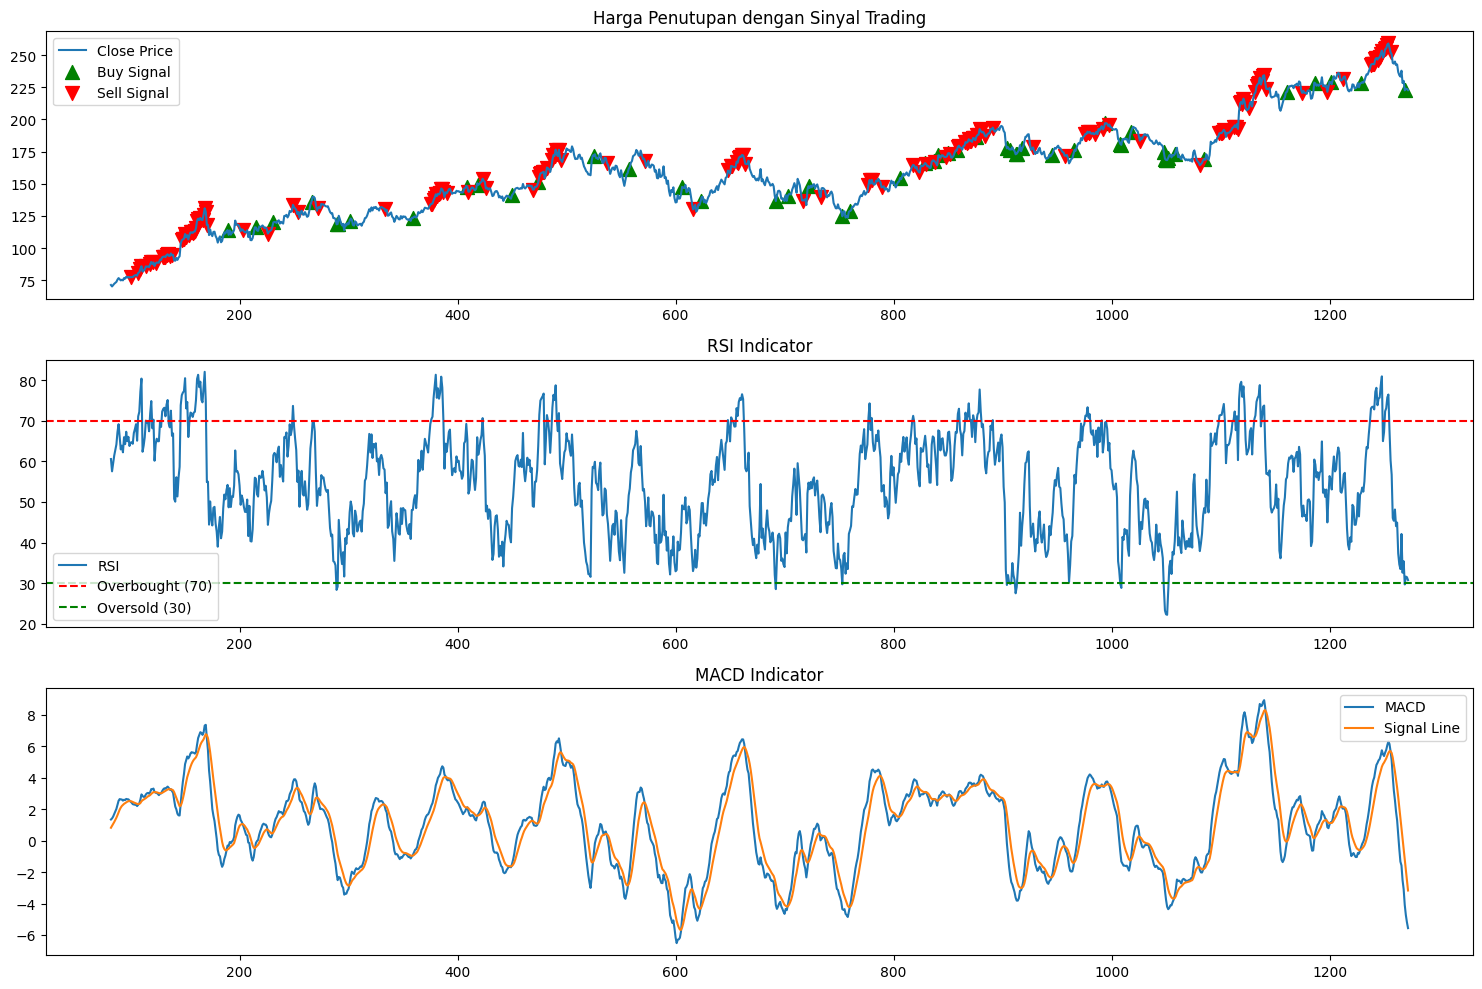

In [173]:
# Visualisasi
plt.figure(figsize=(15, 10))

# Plot close price
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Harga Penutupan dengan Sinyal Trading')

# Menambahkan marker untuk sinyal
buy_signals = df[df['Signal'].isin(['Buy', 'Strong Buy'])]
sell_signals = df[df['Signal'].isin(['Sell', 'Strong Sell'])]

plt.scatter(buy_signals.index, buy_signals['Close'], 
           marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], 
           marker='v', color='r', label='Sell Signal', s=100)
plt.legend()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 3)
plt.plot(df.index, df['MACD'], label='MACD')
plt.plot(df.index, df['MACD_Signal_Line'], label='Signal Line')  # Menggunakan MACD_Signal_Line
plt.title('MACD Indicator')
plt.legend()

plt.tight_layout()
plt.show()

In [174]:
print("\nStatistik Sinyal Trading:")
print(df['Signal'].value_counts())

print("\nSinyal Trading Terakhir:")
print(df[['Close', 'RSI', 'MACD', 'MACD_Signal_Line', 'Signal']].tail())


Statistik Sinyal Trading:
Signal
Hold    967
Sell    173
Buy      51
Name: count, dtype: int64

Sinyal Trading Terakhir:
           Close        RSI      MACD  MACD_Signal_Line Signal
1268  229.979996  35.403532 -3.092244         -0.496565   Hold
1269  222.639999  29.697473 -4.090179         -1.215288    Buy
1270  223.830002  31.621650 -4.730496         -1.918329   Hold
1271  223.660004  31.489059 -5.191822         -2.573028   Hold
1272  222.779999  30.769808 -5.564293         -3.171281   Hold
